# Table of Contents
* [1. compositon](#1.-compositon)
	* [1.1 characters](#1.1-characters)
* [2. objects](#2.-objects)
* [3. descriptions](#3.-descriptions)


In [1]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import functools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import copy
import os
import json
from tqdm import tqdm as tqdm

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import anigen_tools
from anigen_tools.dataset import FlintstonesDataset
from anigen_tools.mturk import unpickle_this, pickle_this

In [2]:
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['patch.linewidth'] = 1

plt.rc('font',**{'family':'serif','serif':['Times']})
# plt.rc('font', family='serif')
# plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})

plt.rc('text', usetex=True)

In [4]:
dataset = unpickle_this('../build_dataset/pickled_data/dataset_full26k.pkl')

In [5]:
def get_vid(video_id, dataset=dataset):
    return [vid for vid in dataset if vid.gid() == video_id][0]

def make_standard_fig(fig_plt, fig_labels=None, save = False, outfile='fig.pdf', main_color=None, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=35, verticalalignment='bottom', color=label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=35, labelpad=10, color=label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=30, labelpad=10, color=label_color)
    plt.tick_params(axis='x', which='major', labelsize=28)
    plt.tick_params(axis='y', which='major', labelsize=23)
    if save:
        plt.savefig(outfile, bbox_inches='tight')

# 1. compositon

## 1.1 characters

In [6]:
vid_count = len(dataset)

In [7]:
char_counts = pd.Series([len(vid.data()['characters']) for vid in dataset])
count_dist = char_counts.value_counts()
norm_count_dist = count_dist / count_dist.sum()

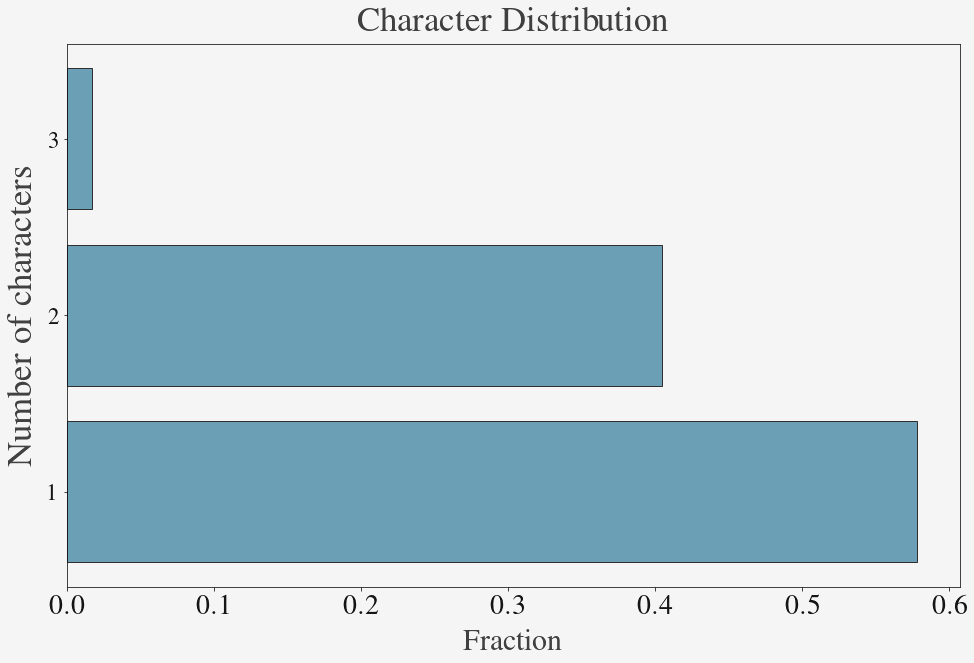

In [8]:
fig_labels = {
    'fig_title': 'Character Distribution', 
    'x_label': 'Fraction',
    'y_label': 'Number of characters'
}

fig = plt.barh(norm_count_dist.index, norm_count_dist.values)
_ = make_standard_fig(fig, fig_labels, save=False)
_ = plt.yticks(np.arange(1, 4, 1))

# 2. objects

In [11]:
obj_counts = pd.Series([len(vid.data()['objects']) for vid in dataset])
o_count_dist = obj_counts.value_counts()
norm_o_count_dist = o_count_dist / o_count_dist.sum()

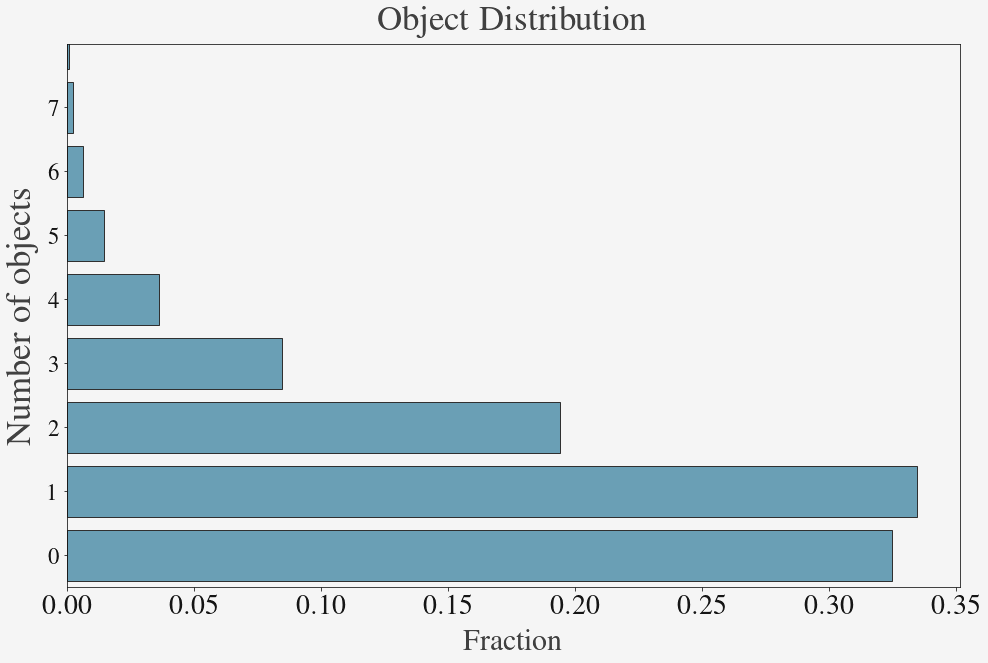

In [12]:
fig_labels = {
    'fig_title': 'Object Distribution', 
    'x_label': 'Fraction',
    'y_label': 'Number of objects'
}

fig = plt.barh(norm_o_count_dist.index, norm_o_count_dist.values)
_ = make_standard_fig(fig, fig_labels, save=True)
_ = plt.yticks(np.arange(0, 8, 1))
_ = plt.ylim(-0.5, 8)

# 3. descriptions

In [13]:
desc_lens = pd.Series([len(vid.description().split()) for vid in dataset])

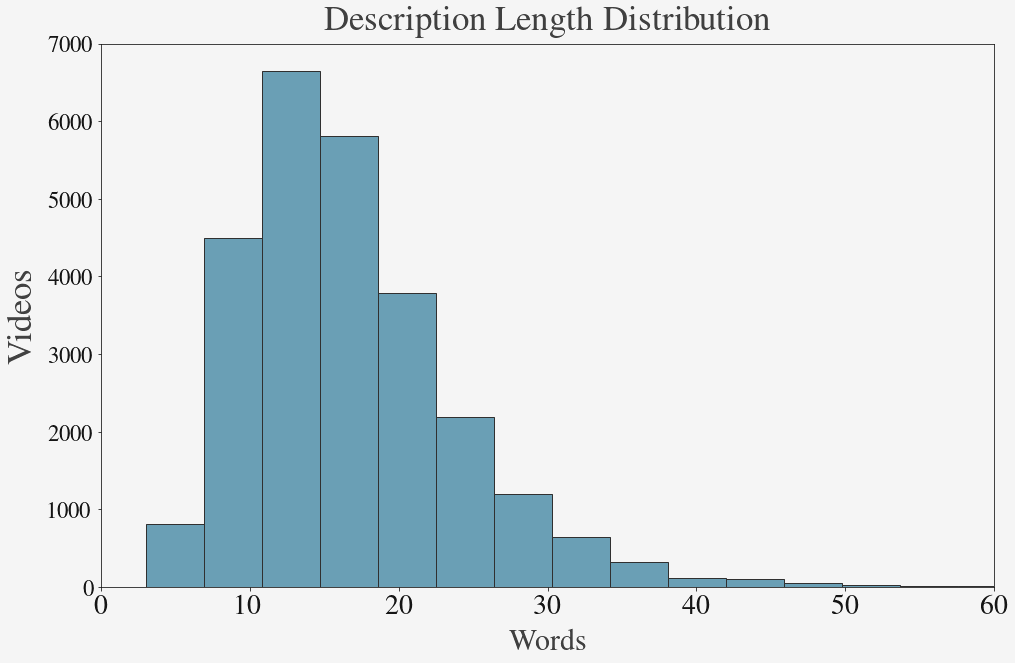

In [14]:
fig_labels = {
    'fig_title': 'Description Length Distribution', 
    'x_label': '# Words',
    'y_label': '# Videos'
}

fig = desc_lens.hist(bins=20)
_ = make_standard_fig(fig, fig_labels, save=False)
# _ = plt.yticks(np.arange(0, 8, 1))
_ = plt.xlim(0, 60)
_ = plt.ylim(0, 7000)

# experiment

In [18]:
def filter_chars(vid, n_chars = None, chars_required=None):
    len_match =  len(vid.data()['characters']) == n_chars
    chars_present = set([char.data()['entityLabel'] for char in vid.data()['characters']])
    chars_satisfied = len(set(chars_present).intersection(set(chars_required))) == len(chars_required)
    return len_match and chars_satisfied

def filter_description(vid, contains=None, doesnot_contain=None):
    contains_satisfied = sum([phrase.lower() in vid.description() for phrase in contains]) == len(contains)
    doesnot_contains_satisfied = sum([phrase.lower() not in vid.description() for phrase in doesnot_contain]) == len(doesnot_contain)


def vid_filter(vid, filters):
    return sum([filt(vid) for filt in filters]) == len(filters)

In [10]:
filters_to_apply = [functools.partial(filter_chars, n_chars=1, chars_required=['fred'])]

In [11]:
vid_list = [vid for vid in dataset if vid_filter(vid, filters_to_apply)]

In [12]:
im_list = [vid.get_key_frame_images(spec_frame=1)[0] for vid in vid_list]

In [15]:
width, height = im_list[0].size
n_imgs = len(im_list)
avg_arr = np.zeros((height, width , 3), np.float)

for im in tqdm(im_list):
    img_arr = np.array(im, dtype=np.float)
    avg_arr += img_arr / n_imgs
    
avg_arr = np.array(np.round(avg_arr), dtype=np.uint8)

100%|██████████| 6323/6323 [01:53<00:00, 55.68it/s]


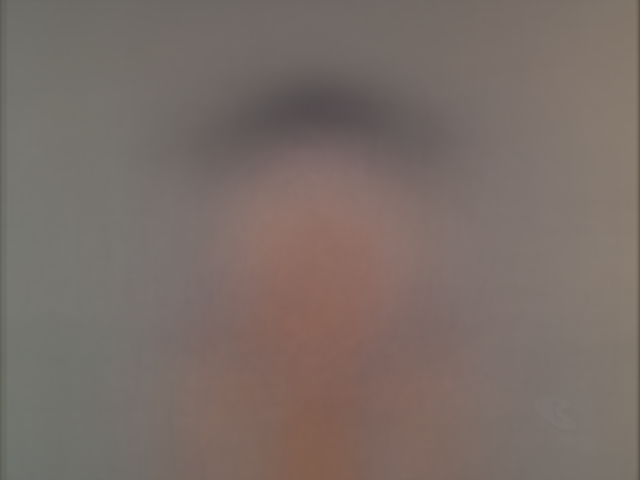

In [16]:
pil.fromarray(avg_arr, mode="RGB")